## Predicting House Prices - Kaggle Competition
One of Kaggle's basic competitions is for predicting house prices, based on a small dataset wih 79 features. This dataset is great practice for certain basics in data science such as cleaning, feature engineering and building powerful regression models. 
This notebook covers my attempt at the competition, and my best RMLSE score is 0.12365, putting me roughly in the top 20% of the leaderboard at the time.

Competition link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

I have highlighted certain cells which have code snippets inspired/taken from the work in this notebook: https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
y_train = train_data["SalePrice"]
train_data = train_data.drop(["Id"], axis=1)
test_data = test_data.drop(["Id"], axis=1)

train_rows = train_data.shape[0]

In [4]:
full_data = pd.concat((train_data.drop("SalePrice", axis=1), test_data)).reset_index(drop=True)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

# Data Cleaning

In [5]:
full_data['MSSubClass'] = full_data['MSSubClass'].apply(str)
full_data['YrSold'] = full_data['YrSold'].astype(str)
full_data['MoSold'] = full_data['MoSold'].astype(str)

The features MSSubclass, YrSold and MoSold are listed as being integers here, despite their domains are small discrete sets of values. It would make more sense to change them to strings so they can be treated as categorical features when building dummy variables later on.

Let's look at the full list of features with missing values:

In [6]:
null_data = full_data.isnull().sum().sort_values(ascending=False)
null_data[null_data > 0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior1st        1
SaleType           1
Electrical         1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64

Firstly, I'm going to use imputation to fill in the missing values of certain features.

In [7]:
full_data['Functional'] = full_data['Functional'].fillna(full_data['Functional'].mode()[0])
full_data['Electrical'] = full_data['Electrical'].fillna(full_data['Electrical'].mode()[0])
full_data['KitchenQual'] = full_data['KitchenQual'].fillna(full_data['KitchenQual'].mode()[0])
full_data['Exterior1st'] = full_data['Exterior1st'].fillna(full_data['Exterior1st'].mode()[0])
full_data['Exterior2nd'] = full_data['Exterior2nd'].fillna(full_data['Exterior2nd'].mode()[0])
full_data['SaleType'] = full_data['SaleType'].fillna(full_data['SaleType'].mode()[0])
full_data['MSZoning'] = full_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
full_data['LotFrontage'] = full_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

Next I shall get a list of all the string features in this dataset so I can blanket fill in their missing values.

In [8]:
string_features = []
for i in full_data.columns:
    if full_data[i].dtype == object:
        string_features.append(i)
string_features = np.array(string_features)
string_features

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'YrSold', 'SaleType', 'SaleCondition'], dtype='<U13')

All of these features shall have their missing values filled in with "None", so this can be treated as a new category.

In [9]:
for feature in string_features:
    full_data[feature] = full_data[feature].fillna("None")

Next I'm getting all the numeric features to once again blanket fill in their missing values.

In [10]:
numeric_features = []
for i in full_data.columns:
    if full_data[i].dtype in ['int64','float64']:
        numeric_features.append(i)     
numeric_features = np.array(numeric_features)
numeric_features

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'], dtype='<U13')

In [11]:
for feature in numeric_features:
    full_data[feature] = full_data[feature].fillna(0)

Now that all the missing numeric values have been filled in with 0, I shall check to make sure there are no features remaining with missing values:

In [12]:
null_data = full_data.isnull().sum()
null_data[null_data > 0]

Series([], dtype: int64)

# Skewness in the Data
Let's check the skewness of the numeric features, including the target feature, SalePrice.

Skewness: 1.8828757597682129


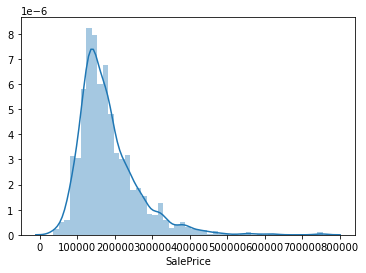

In [13]:
print("Skewness: {}".format(y_train.skew()))
sns.distplot(y_train)

You can clearly see from the distribution plot above that the SalePrice target feature is skewed to the left. We can fix this using a log transformation:

Skewness: 0.12134661989685333


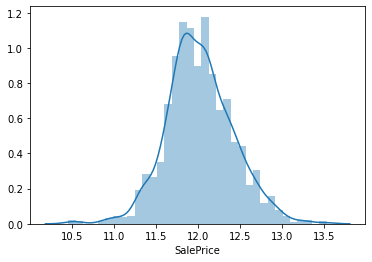

In [14]:
y_train = np.log1p(y_train)
y_train = y_train.reset_index(drop=True)
print("Skewness: {}".format(y_train.skew()))
sns.distplot(y_train)

Now the distribution of SalePrice is more balanced. I have transformed the data using a log(1+x) transformation rather than log(x), because if x=0, log(x) becomes negative infinity. 

In [15]:
skewness = full_data[numeric_features].skew(axis=0).sort_values(ascending=False)
skewness

MiscVal          21.958480
PoolArea         16.907017
LotArea          12.829025
LowQualFinSF     12.094977
3SsnPorch        11.381914
KitchenAbvGr      4.304467
BsmtFinSF2        4.148275
EnclosedPorch     4.005950
ScreenPorch       3.948723
BsmtHalfBath      3.933616
MasVnrArea        2.614936
OpenPorchSF       2.536417
WoodDeckSF        1.843380
LotFrontage       1.506478
1stFlrSF          1.470360
BsmtFinSF1        1.425963
GrLivArea         1.270010
TotalBsmtSF       1.157489
BsmtUnfSF         0.919812
2ndFlrSF          0.862118
TotRmsAbvGrd      0.758757
Fireplaces        0.733872
HalfBath          0.694924
BsmtFullBath      0.625153
OverallCond       0.570605
BedroomAbvGr      0.326492
GarageArea        0.239380
OverallQual       0.197212
FullBath          0.167692
GarageCars       -0.219694
YearRemodAdd     -0.451252
YearBuilt        -0.600114
GarageYrBlt      -3.908213
dtype: float64

Now I'm looking at the skewness of the rest of the numeric features in the dataset. Any features that have skew > 0.5 will also be transformed using box-cox transformation of 1+x (again to avoid any zero values causing unwanted problems). 

In [16]:
high_skewness = skewness[skewness > 0.5]
print("{} numerial features with skew > 0.5".format(high_skewness.shape[0]))

25 numerial features with skew > 0.5


In [17]:
#box-cox transformation idea taken from: https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

for i in high_skewness.index:
    full_data[i] = boxcox1p(full_data[i], boxcox_normmax(full_data[i] + 1))

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:3538: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [18]:
skewness = full_data[high_skewness.index].skew(axis=0).sort_values(ascending=False)
skewness

PoolArea         14.993700
3SsnPorch         8.869703
LowQualFinSF      8.499971
MiscVal           5.242589
BsmtHalfBath      3.782904
KitchenAbvGr      3.781840
ScreenPorch       3.155533
BsmtFinSF2        2.580794
EnclosedPorch     2.151263
MasVnrArea        0.976856
2ndFlrSF          0.894996
WoodDeckSF        0.785172
HalfBath          0.731147
OpenPorchSF       0.621345
BsmtFullBath      0.618737
Fireplaces        0.554807
OverallCond       0.383197
BsmtFinSF1        0.374894
TotalBsmtSF       0.369852
BsmtUnfSF         0.054231
TotRmsAbvGrd      0.047250
LotFrontage       0.036146
GrLivArea         0.004851
1stFlrSF         -0.011617
LotArea          -0.135470
dtype: float64

We can see above that despite the skew values are not all close to zero, they have still been lowered from what they were before the box-cox transformation.

# Removing Outliers
I shall split the data back into training and test sets, because I only want to look at the training set when removing outliers. I'm going to look for outliers visually using scatterplots of the numeric features.

In [19]:
train_data = full_data[:train_rows]
train_data["SalePrice"] = y_train.values
test_data = full_data[train_rows:]

print(train_data.shape)
print(test_data.shape)

(1460, 80)
(1459, 79)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


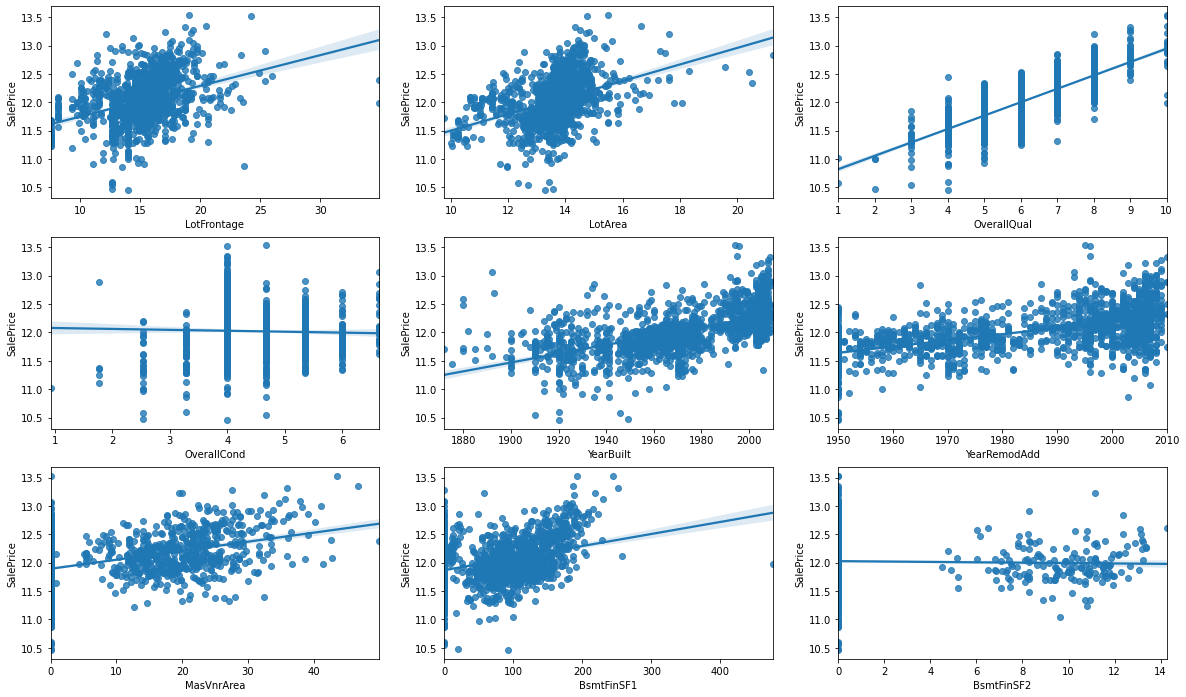

In [20]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()

features = numeric_features[:9]
for i in range(9):
    sns.regplot(x=features[i], y="SalePrice", data=train_data, ax=ax[i])

In [21]:
train_data = train_data[(train_data["OverallCond"] > 2) | (train_data["SalePrice"] < 12.5)]
train_data = train_data[train_data["LotFrontage"] < 30]
train_data = train_data[train_data["BsmtFinSF1"] < 400]
train_data.shape

(1457, 80)

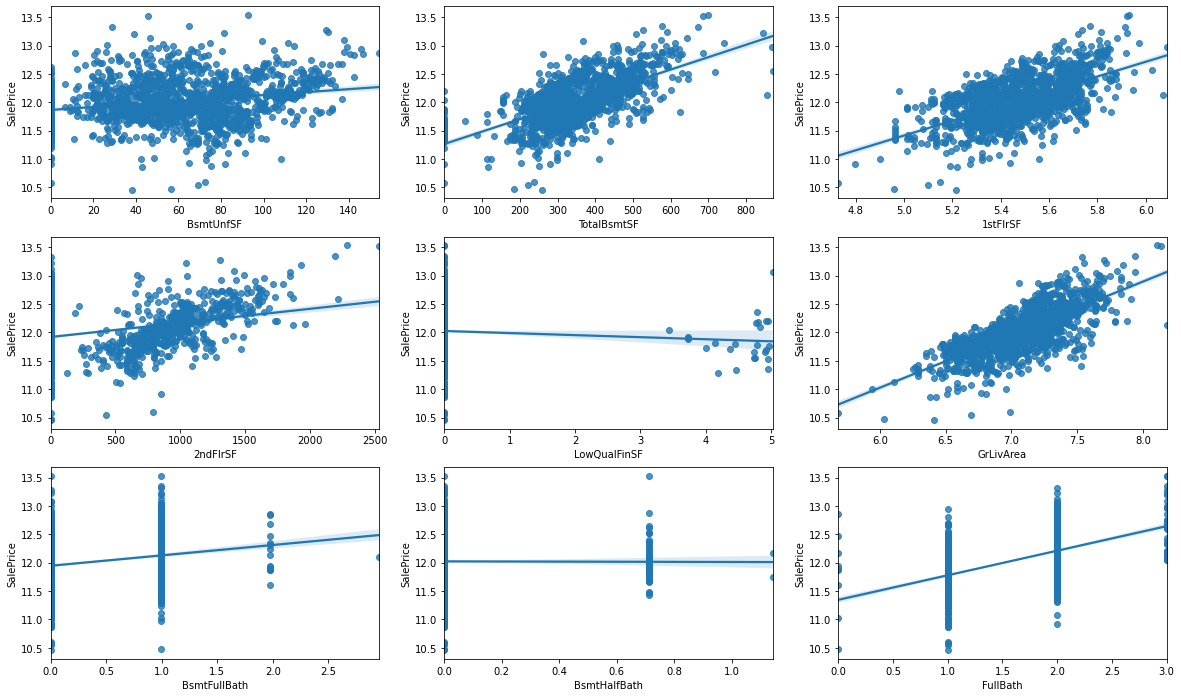

In [22]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()

features = numeric_features[9:18]
for i in range(9):
    sns.regplot(x=features[i], y="SalePrice", data=train_data, ax=ax[i])

In [23]:
train_data = train_data[(train_data["LowQualFinSF"] < 5) | (train_data["SalePrice"] < 12.75)]
train_data = train_data[(train_data["GrLivArea"] < 8) | (train_data["SalePrice"] > 12.5)]
train_data.shape

(1455, 80)

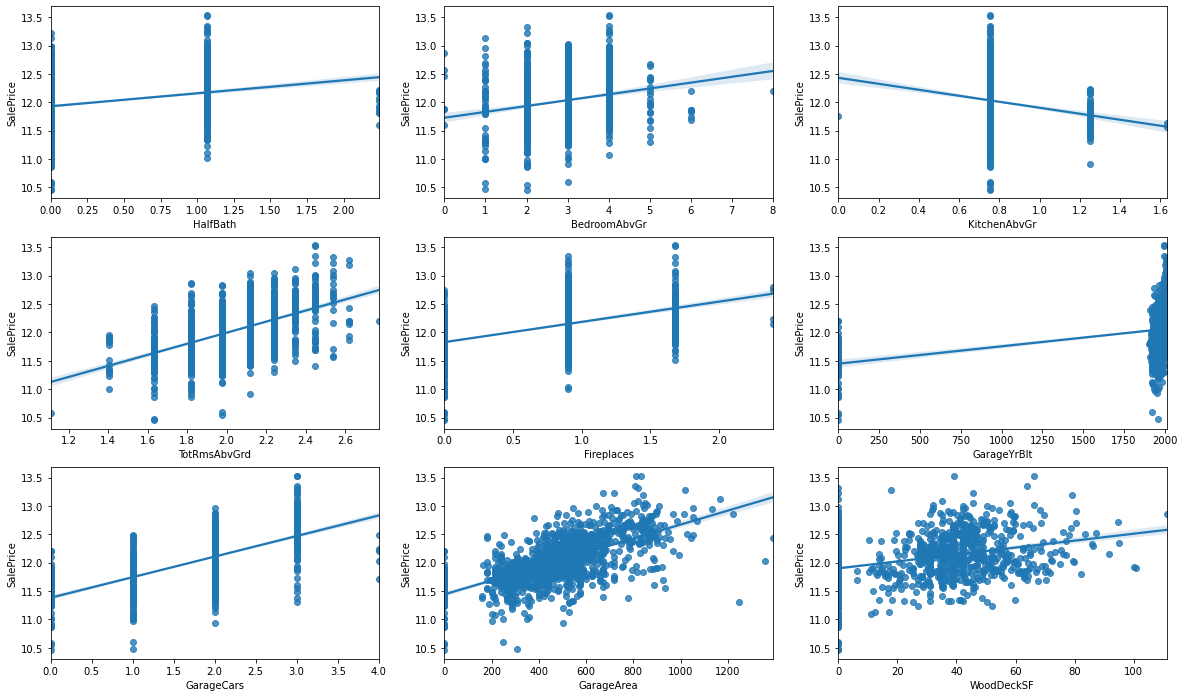

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
ax = ax.flatten()

features = numeric_features[18:27]
for i in range(9):
    sns.regplot(x=features[i], y="SalePrice", data=train_data, ax=ax[i])

In [25]:
train_data = train_data[(train_data["GarageArea"] < 1200) | (train_data["SalePrice"] > 11.5)]
train_data.shape

(1454, 80)

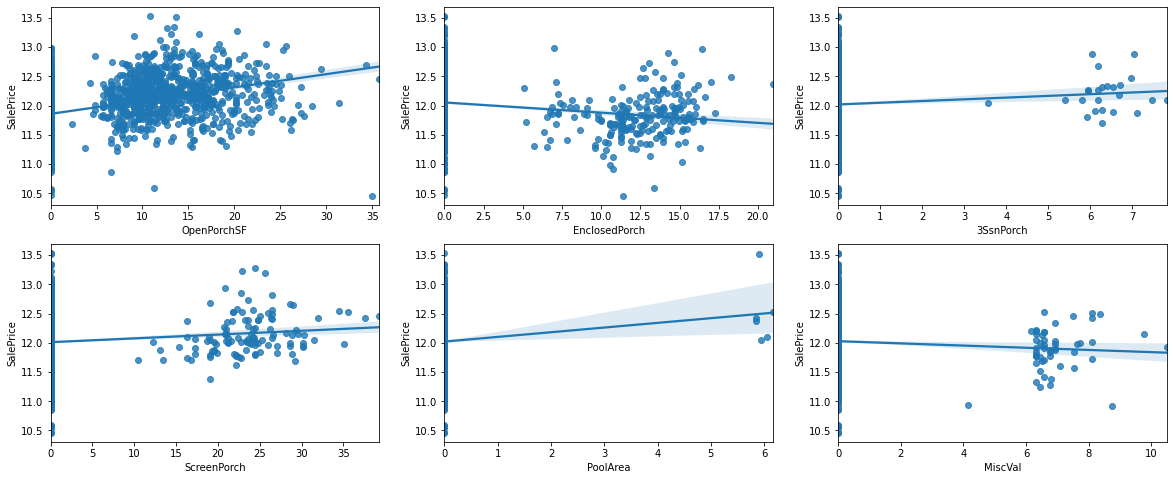

In [26]:
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
ax = ax.flatten()

features = numeric_features[27:33]
for i in range(6):
    sns.regplot(x=features[i], y="SalePrice", data=train_data, ax=ax[i])

In [27]:
train_data = train_data[(train_data["PoolArea"] < 5) | (train_data["SalePrice"] < 13)]
train_data = train_data[(train_data["OpenPorchSF"] < 30) | (train_data["SalePrice"] > 11)]
train_data.shape

(1452, 80)

After looking through all the numeric features for outliers, a total of 8 rows have been removed from the training set.

# Feature Engineering
I'm going to merge the training and test set back together again whilst I create new features.


In [28]:
full_data['YrBltAndRemod'] = full_data['YearBuilt'] + full_data['YearRemodAdd']

full_data['TotalSF'] = full_data['1stFlrSF'] + full_data['2ndFlrSF'] + full_data['TotalBsmtSF'] + full_data['BsmtFinSF1'] + full_data['BsmtFinSF2']

full_data['Total_Porch_Area'] = full_data['OpenPorchSF'] + full_data['3SsnPorch'] + full_data['EnclosedPorch'] + full_data['ScreenPorch'] + full_data['WoodDeckSF']

full_data['Total_Baths'] = full_data['FullBath'] + 0.5*full_data['HalfBath'] + full_data['BsmtFullBath'] + 0.5*full_data['BsmtHalfBath']

full_data['PoolExists'] = full_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

full_data['2ndFloorExists'] = full_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

full_data['GarageExists'] = full_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

full_data['FireplaceExists'] = full_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

full_data['BsmtExists'] = full_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

In [29]:
y_train = train_data["SalePrice"]
train_rows = train_data.shape[0]
full_data = pd.concat((train_data.drop("SalePrice", axis=1), test_data))
full_data = pd.get_dummies(full_data)
full_data.shape

(2911, 332)

After manually creating some new features, as well as creating dummies for all categorical variables, the dataset now has 332 features, up from 79 originally. The dataset can now be split back into training and test sets for one last time so I can start building models for the data.

In [30]:
train_data = full_data[:train_rows]
test_data = full_data[train_rows:]

print(train_data.shape)
print(test_data.shape)

(1452, 332)
(1459, 332)


In [31]:
# idea of removing overfit fea

overfit_features = []
for i in train_data.columns:
    counts = train_data[i].value_counts()
    highest_count = counts.iloc[0]
    if highest_count / len(train_data) * 100 > 99.95:
        overfit_features.append(i)

overfit_features = list(overfit_features)
train_data = train_data.drop(overfit_features, axis=1)
test_data = test_data.drop(overfit_features, axis=1)

print(train_data.shape)
print(test_data.shape)

(1452, 330)
(1459, 330)


2 features have been removed that have >99.95% of their data as the same value. This helps a little bit more to prevent overfitting. 

# Building Regression Models
I'm going to build a range of models, from Ridge regression to gradient boosting.

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [33]:
lgb = LGBMRegressor(objective='regression', learning_rate=0.05, n_estimators=1000, nthreads=4, random_state=1)

xgb = XGBRegressor(learning_rate=0.05, n_estimators=1000, n_jobs=4, random_state=1)

ridge = make_pipeline(RobustScaler(), Ridge(random_state=1))

svr = make_pipeline(RobustScaler(), SVR())

gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, random_state=1)  

rf = RandomForestRegressor(n_estimators=1000, max_depth=15, n_jobs=4, random_state=1)

stackCV = StackingCVRegressor(regressors=(xgb, lgb, svr, ridge, gb, rf), meta_regressor=xgb, use_features_in_secondary=True, random_state=1)

In [34]:
print("Fitting models: \n")

stackCV.fit(np.array(train_data), np.array(y_train))
print('stackCV')
ridge.fit(train_data, y_train)
print('ridge')
svr.fit(train_data, y_train)
print('svr')
gb.fit(train_data, y_train)
print('gb')
xgb.fit(train_data, y_train)
print('xgb')
lgb.fit(train_data, y_train)
print('lgb')
rf.fit(train_data, y_train)
print('rf')

Fitting models: 

stackCV
ridge
svr
gb
xgb
lgb
rf


In [35]:
# idea and percentage values for combining regression models taken from: https://www.kaggle.com/hemingwei/top-2-from-laurenstc-on-house-price-prediction

def combine_predict(X):
    return ((0.1 * ridge.predict(X)) + \
        (0.2 * svr.predict(X)) + \
        (0.1 * gb.predict(X)) + \
        (0.1 * xgb.predict(X)) + \
        (0.1 * lgb.predict(X)) + \
        (0.05 * rf.predict(X)) + \
        (0.35 * stackCV.predict(np.array(X))))

np.sqrt(mean_squared_log_error(y_train, combine_predict(train_data)))

0.0025233549815584437

With the models trained, I shall now use the combined regression models to predict the sale prices for the test set. The labels for the test set are not provided as this is part of a competition. However my highest RMSLE score is 0.12365

In [36]:
y_pred = np.floor(np.expm1(combine_predict(test_data)))

submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.iloc[:, 1] = y_pred
submission.to_csv('submission.csv', index=False)

# Conclusion
My attempts at this competition have taught me a lot about the many things one should look at even with a relatively small dataset. Aspects such as the skewness of the data, combining different regression models and ways of engineering new features. This dataset is part of a practice competition therefore many Kaggle users have shared their own work to educate others on how to achieve a good score. I have learnt that looking at other peoples work is a very fast way of learning new skills and knowledge that you can apply later on. It's particularly useful for being introduced to new libraries, as well as the workflow and mindset of professional data scientists with years of experience.